<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/Shallow/10_Per_Linear_Evaluation_Imagenet_Subset_Shallow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 12:52:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restoring model weights

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/Souradip\ Sayak/SimCLR_PseudoLabels/Models/resnet_simclr_modified_ae_shallow.h5 .

In [5]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset gathering and preparation

In [6]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 47.11 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [7]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [8]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [9]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [10]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

  5%|▌         | 13/250 [00:00<00:01, 124.29it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 200.18it/s]


(250, 224, 224, 3) (250,)


In [11]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [12]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [13]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('resnet_simclr_modified_ae_shallow.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [14]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [15]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [16]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [17]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/100
2/2 [==============================] - 0s 68ms/step - loss: 3.5511 - accuracy: 0.2080 - val_loss: 2.7294 - val_accuracy: 0.3160
Epoch 2/100
2/2 [==============================] - 0s 12ms/step - loss: 3.2174 - accuracy: 0.2080 - val_loss: 2.4944 - val_accuracy: 0.3200
Epoch 3/100
2/2 [==============================] - 0s 11ms/step - loss: 2.9402 - accuracy: 0.2080 - val_loss: 2.2998 - val_accuracy: 0.3400
Epoch 4/100
2/2 [==============================] - 0s 11ms/step - loss: 2.6945 - accuracy: 0.2320 - val_loss: 2.1397 - val_accuracy: 0.3640
Epoch 5/100
2/2 [==============================] - 0s 11ms/step - loss: 2.4727 - accuracy: 0.2320 - val_loss: 2.0147 - val_accuracy: 0.3680
Epoch 6/100
2/2 [==============================] - 0s 11ms/step - loss: 2.3004 - accuracy: 0.2400 - val_loss: 1.9164 - val_accuracy: 0.3760
Epoch 7/100
2/2 [==============================] - 0s 11ms/step - loss: 2.1418 - accuracy: 0.2480 - val_loss: 1.8411 - val_accuracy: 0.3920
Epoch 8/100
2/2 [===

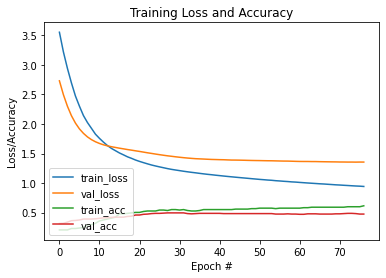

In [18]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [19]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


Epoch 1/35
2/2 [==============================] - 0s 52ms/step - loss: 3.0682 - accuracy: 0.2480 - val_loss: 2.4553 - val_accuracy: 0.2880
Epoch 2/35
2/2 [==============================] - 0s 11ms/step - loss: 2.4965 - accuracy: 0.2800 - val_loss: 2.1490 - val_accuracy: 0.2560
Epoch 3/35
2/2 [==============================] - 0s 11ms/step - loss: 2.1719 - accuracy: 0.3280 - val_loss: 2.0690 - val_accuracy: 0.2720
Epoch 4/35
2/2 [==============================] - 0s 11ms/step - loss: 2.0535 - accuracy: 0.3360 - val_loss: 2.1035 - val_accuracy: 0.2960
Epoch 5/35
2/2 [==============================] - 0s 11ms/step - loss: 2.0121 - accuracy: 0.3760 - val_loss: 2.1328 - val_accuracy: 0.3240
Epoch 00005: early stopping


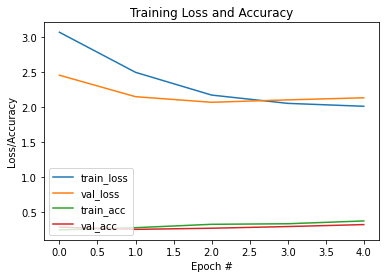

In [20]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [21]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


Epoch 1/35
2/2 [==============================] - 0s 53ms/step - loss: 2.4121 - accuracy: 0.2240 - val_loss: 2.3577 - val_accuracy: 0.1640
Epoch 2/35
2/2 [==============================] - 0s 13ms/step - loss: 2.2345 - accuracy: 0.2320 - val_loss: 1.8293 - val_accuracy: 0.2760
Epoch 3/35
2/2 [==============================] - 0s 12ms/step - loss: 1.6834 - accuracy: 0.2320 - val_loss: 1.6835 - val_accuracy: 0.2120
Epoch 4/35
2/2 [==============================] - 0s 12ms/step - loss: 1.6401 - accuracy: 0.2720 - val_loss: 1.5664 - val_accuracy: 0.3120
Epoch 5/35
2/2 [==============================] - 0s 12ms/step - loss: 1.4192 - accuracy: 0.4400 - val_loss: 1.3891 - val_accuracy: 0.4320
Epoch 6/35
2/2 [==============================] - 0s 11ms/step - loss: 1.2701 - accuracy: 0.4400 - val_loss: 1.4299 - val_accuracy: 0.4080
Epoch 7/35
2/2 [==============================] - 0s 12ms/step - loss: 1.2650 - accuracy: 0.4080 - val_loss: 1.4825 - val_accuracy: 0.3720
Epoch 00007: early stopping

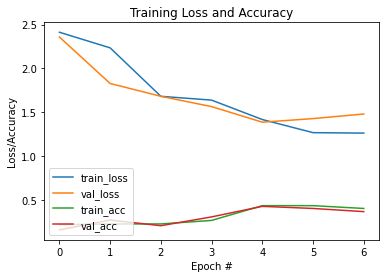

In [22]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)